# Task 1-1: Double-pendulum problem
This notebook is to visualize how all networks performs when simulating double-pendulum systems.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch, time, sys
import numpy as np
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = '../experiment-pend-2+'
sys.path.append(EXPERIMENT_DIR)

MODEL_DIR = '../src'
sys.path.append(MODEL_DIR)

from layers import MLP
from models import HNN, ModLaNet
from utils import L2_loss
from data import Dataset

In [2]:
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"]  = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
wordsize = 18
plt.rc('font', size=wordsize)          # controls default text sizes
plt.rc('axes', titlesize=wordsize)     # fontsize of the axes title
plt.rc('axes', labelsize=wordsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=wordsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=wordsize)    # legend fontsize
plt.rc('figure', titlesize=wordsize)  # fontsize of the figure title

## Set some notebook constants

In [4]:
DPI = 300
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 30 # 100 for pend-sim, 30 for pend-real
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'obj': 2,
            'dof': 1,
            'dim': 2,
            'hidden_dim': 200,
            'nonlinearity': 'tanh',
            'trans_hidden_dim': 16,
            'trans_nonlinearity': 'tanh',
            'energy_hidden_dim': 50,
            'energy_nonlinearity': 'tanh',
            'learn_rate': 1e-3,
            'input_noise': 0.5,
            'end_epoch': 10000,
            'field_type': 'solenoidal',
            'gridsize': 10,
            'verbose': True,
            'print_every': 100,
            'name': 'pend',
            'seed': 0,
            'save_dir': './{}'.format(EXPERIMENT_DIR+'/data'),
            'result_dir': '../results'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView(get_args())

## Construct models

In [5]:
def BuildComputationTree(transform = 'local', obj=2, dim=2, dof=1, device = 'cpu'):
    r"""
    User defined relations between elements and origins of local coordinate systems.
    We assume that these connections between origins and elements 
    can be obtained when local coordinate systems are constructed.

    Function: x_{i, origin} =   \sum_j x_{j, element} * weight_j + 
                                \sum_k x_{k, origin}  * weight_k + 
                                weight_c
    Form: [[i, 
            [[j1, weight_j1], [j2, weight_j2], ...], 
            [[k1, weight_k1], [k2, weight_k2], ...], 
            weight_c], ...]
    """
    tree = None
    if transform == 'local':
        ################################
        # User defined relations start #
        ################################
        ele  = [0, [], [], torch.zeros((dim), device = device)]
        tree = [ele]
        for i in range(1, obj):
            ele  = [i, [[i-1, 1.]], [], torch.zeros((dim), device = device)]
            tree.append(ele)
        ################################
        # User defined relations end   #
        ################################
    return tree

In [6]:
def get_model(args, model_name, end_epoch, noise, learn_rate, hidden_dim = None, load_obj = None):
    load_obj = args.obj if load_obj is None else load_obj
    hidden_dim = args.hidden_dim if hidden_dim is None else hidden_dim
    path = '{}/model-{}-{}-{}-hidden_dim-{}-end_epoch-{}-noise-{}-learn_rate-{}.tar'.format(args.save_dir, load_obj, args.name,
                                                                           model_name, hidden_dim, end_epoch,
                                                                           noise, learn_rate)
    checkpoint = torch.load(path)
    if model_name == 'modlanet':
        model = ModLaNet(obj=load_obj, dim=args.dim, edof=args.dof, build_computation_tree=BuildComputationTree, transform = 'local',
                         trans_hidden_dim = args.trans_hidden_dim, trans_nonlinearity = args.trans_nonlinearity, 
                         energy_hidden_dim = args.energy_hidden_dim)
        model.load_state_dict(checkpoint['network_state_dict'])
    else:
        assert load_obj == args.obj
        input_dim = args.obj * args.dof * 2
        output_dim = input_dim if model_name == 'baseline' else 2
        nn_model = MLP(input_dim, hidden_dim, output_dim, args.nonlinearity)
        model = HNN(input_dim, differentiable_model=nn_model,
                  field_type=args.field_type, baseline= (model_name == 'baseline') )

        model.load_state_dict(checkpoint['network_state_dict'])
    return model

In [7]:
def integrate_model(args, model, t_span, y0, model_name = 'modlanet', **kwargs):
    if model_name == 'modlanet':
        def fun(t, np_x):
            x = torch.tensor( np_x[:args.obj*args.dof] % (2 * np.pi), requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            v = torch.tensor( np_x[args.obj*args.dof:], requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof)
            dx = model.forward(x, v).data.numpy().reshape(-1)
            return np.concatenate((np_x[args.obj*args.dof:], dx))
    else:
        def fun(t, np_x):
            np_x[:args.obj*args.dof] = np_x[:args.obj*args.dof] % (2 * np.pi)
            x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,args.obj*args.dof*2)
            dx = model.time_derivative(x).data.numpy().reshape(-1)
            return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [8]:
# model_name, length, end_epoch, noise, learn_rate
modlanet_model = get_model(args, model_name = 'modlanet', hidden_dim = 50, end_epoch = 10000, noise = 0., learn_rate = 0.01)
base_model = get_model(args, model_name = 'baseline', hidden_dim = 200, end_epoch = 10000, noise = 0., learn_rate = 0.01)
hnn_model = get_model(args, model_name = 'hnn', hidden_dim = 200, end_epoch = 10000, noise = 0., learn_rate = 0.01)
hnn_light_model = get_model(args, model_name = 'hnn', hidden_dim = 75, end_epoch = 10000, noise = 0., learn_rate = 0.01)

# Very unstable, so it is excluded during analysis
base_light_model = get_model(args, model_name = 'baseline', hidden_dim = 75, end_epoch = 10000, noise = 0., learn_rate = 0.01)


## Quantitative analysis

In [9]:
def polar2uv(x, v):
    vel = np.zeros([x.shape[0], x.shape[1]*2])
    for i in range(x.shape[1]):
        if i == 0:
            vel[:, 2*i:2*(i+1)] += np.concatenate([np.cos(x[:,i:i+1]) * v[:,i:i+1], np.sin(x[:,i:i+1]) * v[:,i:i+1]], 1)
        else:
            vel[:, 2*i:2*(i+1)] += vel[:, 2*(i-1):2*i] + np.concatenate([np.cos(x[:,i:i+1]) * v[:,i:i+1], np.sin(x[:,i:i+1]) * v[:,i:i+1]], 1)
    return vel

In [10]:
def polar2xy(x):
    pos = np.zeros([x.shape[0], x.shape[1]*2])
    for i in range(x.shape[1]):
        if i == 0:
            pos[:, 2*i:2*(i+1)] += np.concatenate([np.sin(x[:,i:i+1]), -np.cos(x[:,i:i+1])], 1)
        else:
            pos[:, 2*i:2*(i+1)] += pos[:, 2*(i-1):2*i] + np.concatenate([np.sin(x[:,i:i+1]), -np.cos(x[:,i:i+1])], 1)
    return pos

In [11]:
# np.random.seed(args.seed)
ds = Dataset(args.obj, m= [1. for i in range(args.obj)], l= [1. for i in range(args.obj)])

In [12]:
y0  = np.array([1., 2., 0., 0.])
t_span = [0, 10]
timescale = 50
t_eval = np.linspace(t_span[0], t_span[1], (t_span[1]-t_span[0])*timescale)
kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

truth_ivp = solve_ivp(fun=ds.dynamics_lagrangian_fn, t_span=t_span, y0=y0, **kwargs)
truth_pos = polar2xy(truth_ivp['y'][0:args.obj].T)
truth_vel = polar2uv(truth_ivp['y'][0:args.obj].T, truth_ivp['y'][args.obj:args.obj*2].T)

modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)
modlanet_pos = polar2xy(modlanet_ivp['y'][0:args.obj].T)
modlanet_vel = polar2uv(modlanet_ivp['y'][0:args.obj].T, modlanet_ivp['y'][args.obj:args.obj*2].T)

hnn_ivp = integrate_model(args, hnn_model, t_span, y0, model_name = 'hnn', **kwargs)
hnn_pos = polar2xy(hnn_ivp['y'][0:args.obj].T)
hnn_vel = polar2uv(hnn_ivp['y'][0:args.obj].T, hnn_ivp['y'][args.obj:args.obj*2].T)

base_ivp = integrate_model(args, base_model, t_span, y0, model_name = 'baseline', **kwargs)
base_pos = polar2xy(base_ivp['y'][0:args.obj].T)
base_vel = polar2uv(base_ivp['y'][0:args.obj].T, base_ivp['y'][args.obj:args.obj*2].T)


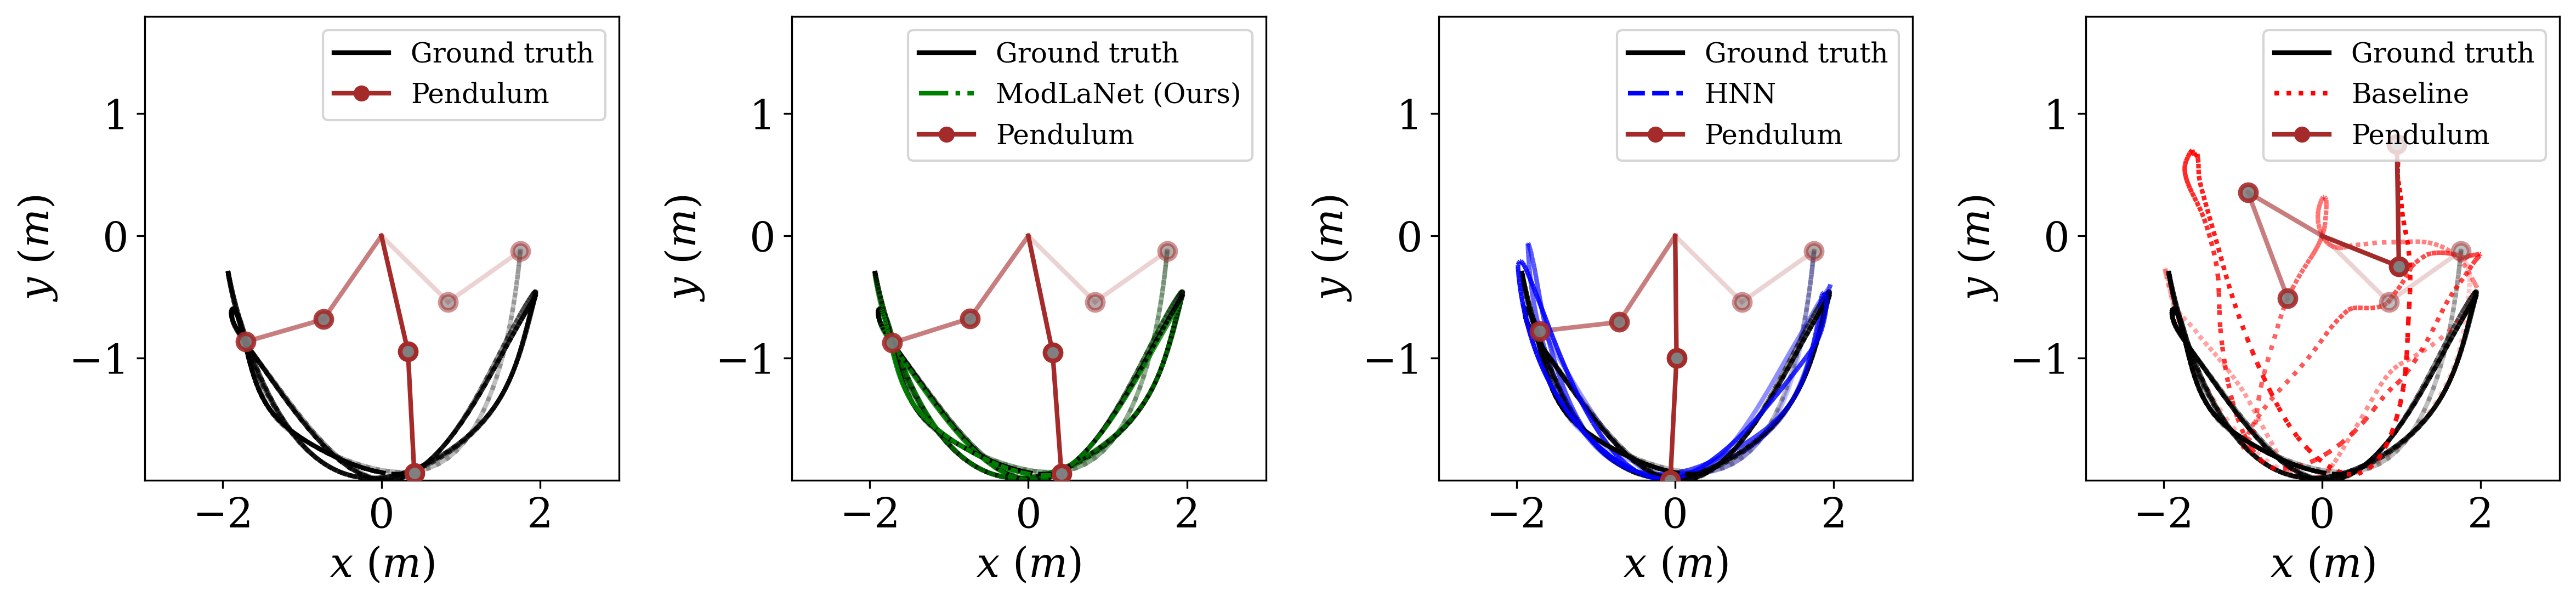

In [13]:
fig = plt.figure(figsize=(16, 4), dpi=DPI)

tpad = 4
time = min(400, len(truth_ivp['y'].T))
legendsize = 12

plt.subplot(1,4,1)
plt.xlabel('$x$ ($m$)') ; plt.ylabel('$y$ ($m$)')
for i in range(time-3):
    plt.plot(truth_pos[i:i+2,2],   truth_pos[i:i+2,3], 'k-', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    if i % 200 == 0:
        plt.plot([0, truth_pos[i, 0]], [0, truth_pos[i, 1]],  color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.plot([truth_pos[i, 0], truth_pos[i, 2]], [truth_pos[i, 1], truth_pos[i, 3]],  'o-', color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.scatter(truth_pos[i, 0], truth_pos[i, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
        plt.scatter(truth_pos[i, 2], truth_pos[i, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
plt.plot(truth_pos[time-2:time,2],   truth_pos[time-2:time,3], 'k-', label='Ground truth', linewidth=2, alpha = 1)
plt.plot([0, truth_pos[time, 0]], [0, truth_pos[time, 1]],  color = 'brown', linewidth = 2, label='_nolegend_')
plt.plot([truth_pos[time, 0], truth_pos[time, 2]], [truth_pos[time, 1], truth_pos[time, 3]],  'o-', color = 'brown', linewidth = 2, label='Pendulum')
plt.scatter(truth_pos[time, 0], truth_pos[time, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)
plt.scatter(truth_pos[time, 2], truth_pos[time, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)

# plt.xlim(min(modlanet_pos[:,2])-1,max(modlanet_pos[:,2])+1) ; plt.ylim(min(modlanet_pos[:,3]),max(modlanet_pos[:,3])+1)
plt.xlim(min(base_pos[:,2])-1,max(base_pos[:,2])+1) ; plt.ylim(min(base_pos[:,3]),max(base_pos[:,3])+1)
plt.legend(fontsize=legendsize)

plt.subplot(1,4,2)
plt.xlabel('$x$ ($m$)') ; plt.ylabel('$y$ ($m$)')
for i in range(time-3):
    plt.plot(truth_pos[i:i+2,2],   truth_pos[i:i+2,3], 'k-', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    plt.plot(modlanet_pos[i:i+2,2], modlanet_pos [i:i+2,3], 'g-.', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    if i % 200 == 0:
        plt.plot([0, modlanet_pos[i, 0]], [0, modlanet_pos[i, 1]],  color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.plot([modlanet_pos[i, 0], modlanet_pos[i, 2]], [modlanet_pos[i, 1], modlanet_pos[i, 3]],  'o-', color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.scatter(modlanet_pos[i, 0], modlanet_pos[i, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
        plt.scatter(modlanet_pos[i, 2], modlanet_pos[i, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
plt.plot(truth_pos[time-2:time,2],   truth_pos[time-2:time,3], 'k-', label='Ground truth', linewidth=2, alpha = 1)
plt.plot(modlanet_pos[time-2:time,2],   modlanet_pos [time-2:time,3], 'g-.', label='ModLaNet (Ours)', linewidth=2, alpha = 1)
plt.plot([0, modlanet_pos[time, 0]], [0, modlanet_pos[time, 1]],  color = 'brown', linewidth = 2, label='_nolegend_')
plt.plot([modlanet_pos[time, 0], modlanet_pos[time, 2]], [modlanet_pos[time, 1], modlanet_pos[time, 3]],  'o-', color = 'brown', linewidth = 2, label='Pendulum')
plt.scatter(modlanet_pos[time, 0], modlanet_pos[time, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)
plt.scatter(modlanet_pos[time, 2], modlanet_pos[time, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)

# plt.xlim(min(modlanet_pos[:,2])-1,max(modlanet_pos[:,2])+1) ; plt.ylim(min(modlanet_pos[:,3]),max(modlanet_pos[:,3])+1)
plt.xlim(min(base_pos[:,2])-1,max(base_pos[:,2])+1) ; plt.ylim(min(base_pos[:,3]),max(base_pos[:,3])+1)
plt.legend(fontsize=legendsize)

plt.subplot(1,4,3)
plt.xlabel('$x$ ($m$)') ; plt.ylabel('$y$ ($m$)')
for i in range(time-3):
    plt.plot(truth_pos[i:i+2,2],   truth_pos[i:i+2,3], 'k-', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    plt.plot(hnn_pos[i:i+2,2],    hnn_pos [i:i+2,3], 'b--', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    if i % 200 == 0:
        plt.plot([0, hnn_pos[i, 0]], [0, hnn_pos[i, 1]],  color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.plot([hnn_pos[i, 0], hnn_pos[i, 2]], [hnn_pos[i, 1], hnn_pos[i, 3]],  'o-', color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.scatter(hnn_pos[i, 0], hnn_pos[i, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
        plt.scatter(hnn_pos[i, 2], hnn_pos[i, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
plt.plot(truth_pos[time-2:time,2],   truth_pos[time-2:time,3], 'k-', label='Ground truth', linewidth=2, alpha = 1)
plt.plot(hnn_pos[time-2:time,2],    hnn_pos [time-2:time,3], 'b--', label='HNN', linewidth=2, alpha = 1)
plt.plot([0, hnn_pos[time, 0]], [0, hnn_pos[time, 1]],  color = 'brown', linewidth = 2, label='_nolegend_')
plt.plot([hnn_pos[time, 0], hnn_pos[time, 2]], [hnn_pos[time, 1], hnn_pos[time, 3]],  'o-', color = 'brown', linewidth = 2, label='Pendulum')
plt.scatter(hnn_pos[time, 0], hnn_pos[time, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)
plt.scatter(hnn_pos[time, 2], hnn_pos[time, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)

plt.xlim(min(base_pos[:,2])-1,max(base_pos[:,2])+1) ; plt.ylim(min(base_pos[:,3]),max(base_pos[:,3])+1)
plt.legend(fontsize=legendsize)

plt.subplot(1,4,4)
# plt.title("Trajectory for object 2"); 
plt.xlabel('$x$ ($m$)') ; plt.ylabel('$y$ ($m$)')
for i in range(time-3):
    plt.plot(truth_pos[i:i+2,2],   truth_pos[i:i+2,3], 'k-', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    plt.plot(base_pos[i:i+2,2],    base_pos [i:i+2,3], 'r:', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
    if i % 200 == 0:
        plt.plot([0, base_pos[i, 0]], [0, base_pos[i, 1]],  color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.plot([base_pos[i, 0], base_pos[i, 2]], [base_pos[i, 1], base_pos[i, 3]],  '-', color = 'brown', linewidth = 2, label='_nolegend_', alpha = 0.2 + 0.8 * (i+1)/time)
        plt.scatter(base_pos[i, 0], base_pos[i, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
        plt.scatter(base_pos[i, 2], base_pos[i, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = min(0.5 + 0.8 * (i+1)/time, 1), zorder = 3)
plt.plot(truth_pos[time-2:time,2],   truth_pos[time-2:time,3], 'k-', label='Ground truth', linewidth=2, alpha = 1)
plt.plot(base_pos[time-2:time,2],    base_pos [time-2:time,3], 'r:', label='Baseline', linewidth=2, alpha = 1)
plt.plot([0, base_pos[time, 0]], [0, base_pos[time, 1]],  color = 'brown', linewidth = 2, label='_nolegend_')
plt.plot([base_pos[time, 0], base_pos[time, 2]], [base_pos[time, 1], base_pos[time, 3]],  'o-', color = 'brown', linewidth = 2, label='Pendulum')
plt.scatter(base_pos[time, 0], base_pos[time, 1], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)
plt.scatter(base_pos[time, 2], base_pos[time, 3], s=50, linewidths = 2, facecolors='gray', edgecolors='brown',  label='_nolegend_', alpha = 1, zorder = 3)

plt.xlim(min(base_pos[:,2])-1,max(base_pos[:,2])+1) ; plt.ylim(min(base_pos[:,3]),max(base_pos[:,3])+1)
plt.legend(fontsize=legendsize)

# plt.xlabel('$x$ ($m$)') ; plt.ylabel('$y$ ($m$)')
# for i in range(time-3):
#     plt.plot(truth_pos[i:i+2,2],   truth_pos[i:i+2,3], 'k-', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
#     plt.plot(base_pos[i:i+2,2],    base_pos [i:i+2,3], 'r:', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
#     plt.plot(hnn_pos[i:i+2,2],    hnn_pos [i:i+2,3], 'b--', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
#     plt.plot(modlanet_pos[i:i+2,2], modlanet_pos [i:i+2,3], 'g-.', label='_nolegend_', linewidth=2, alpha = 0.2 + 0.8 * (i+1)/time)
# plt.plot(truth_pos[time-2:time,2],   truth_pos[time-2:time,3], 'k-', label='Ground truth', linewidth=2, alpha = 1)
# plt.plot(base_pos[time-2:time,2],    base_pos [time-2:time,3], 'r:', label='Baseline', linewidth=2, alpha = 1)
# plt.plot(hnn_pos[time-2:time,2],    hnn_pos [time-2:time,3], 'b--', label='HNN', linewidth=2, alpha = 1)
# plt.plot(modlanet_pos[time-2:time,2],   modlanet_pos [time-2:time,3], 'g-.', label='ModLaNet (Ours)', linewidth=2, alpha = 1) 
# # plt.plot(truth_pos[:time,2],   truth_pos[:time,3], 'k-', label='Ground truth', linewidth=2)
# # plt.plot(hnn_pos[:time,2],     hnn_pos[:time,3], 'b--', label='HNN', linewidth=2)
# # plt.plot(base_pos[:time,2],    base_pos [:time,3], 'r:', label='Baseline', linewidth=2)
# # plt.plot(modlanet_pos[:time,2], modlanet_pos[:time,3], 'g-.', label='ModLaNet (Ours)', linewidth=2)
# plt.xlim(min(base_pos[:,2])-1,max(base_pos[:,2])+1) ; plt.ylim(min(base_pos[:,3]),max(base_pos[:,3])+2)
# plt.legend(fontsize=legendsize)

plt.tight_layout()
fig.savefig('{}/pend-2-integration.{}'.format(args.result_dir, FORMAT), bbox_inches="tight")


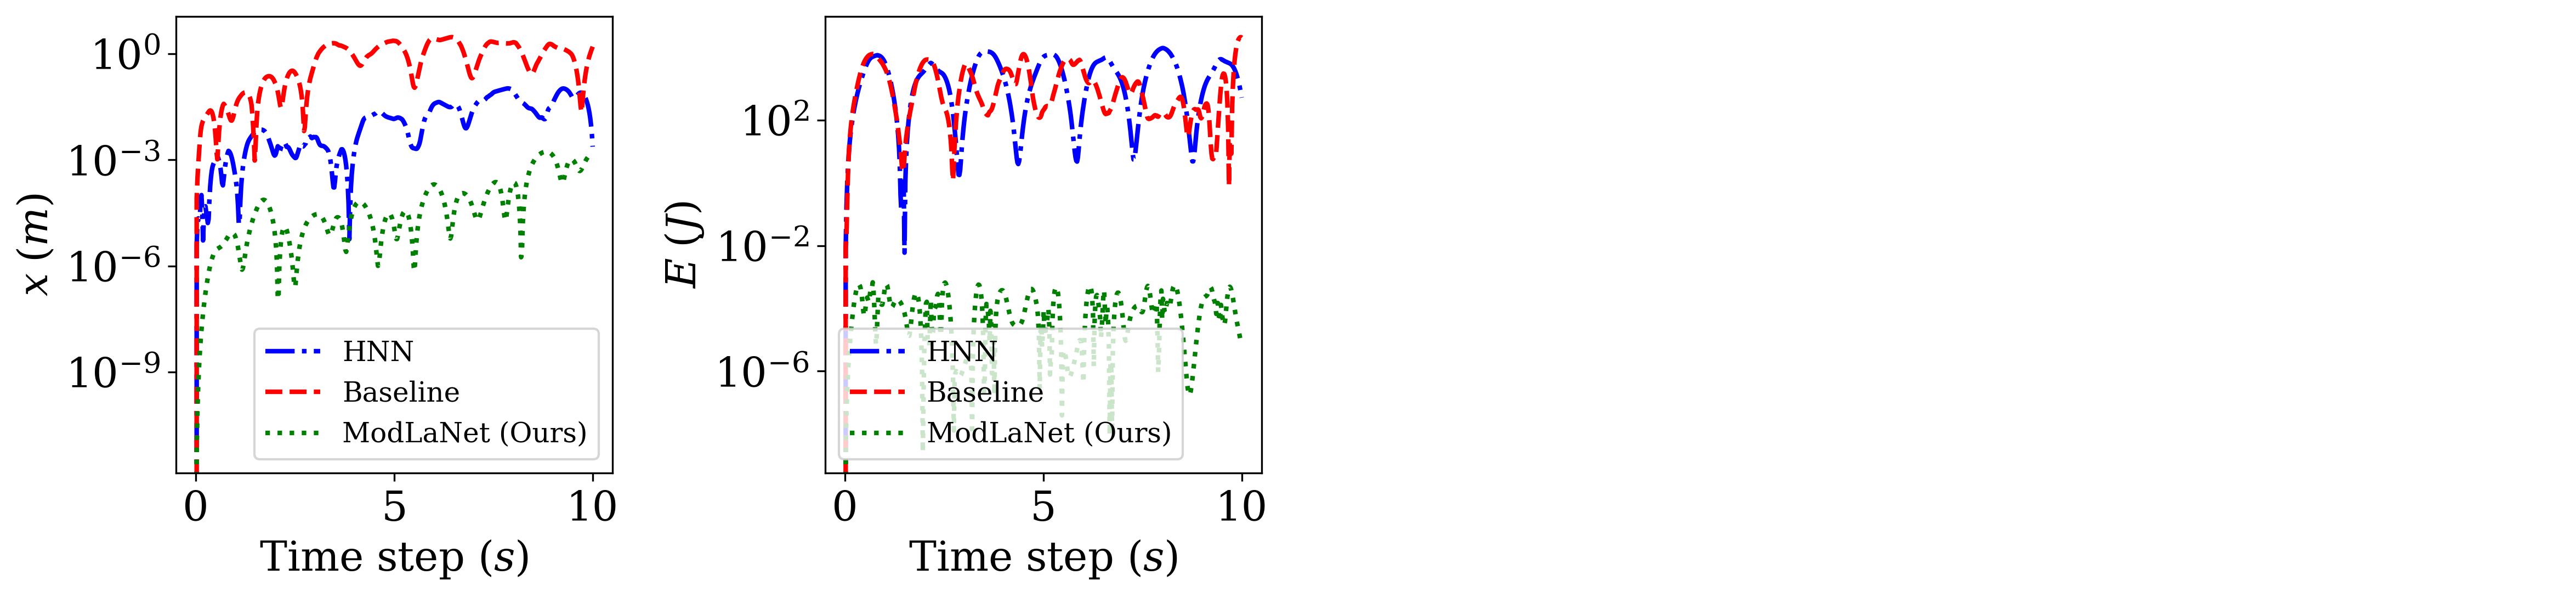

In [14]:
fig = plt.figure(figsize=(16, 4), dpi=DPI)

tpad = 4
time = min(300, len(truth_ivp['y'].T))
legendsize = 12

plt.subplot(1,4,1)


# plt.title("MSE between coordinates") ; 
plt.xlabel('Time step ($s$)'); plt.ylabel('$x\;(m)$')
plt.semilogy(t_eval, ((truth_pos-hnn_pos)**2).mean(-1), 'b-.', label='HNN', linewidth=2)
plt.semilogy(t_eval, ((truth_pos-base_pos)**2).mean(-1), 'r--', label='Baseline', linewidth=2)
plt.semilogy(t_eval, ((truth_pos-modlanet_pos)**2).mean(-1), 'g:', label='ModLaNet (Ours)', linewidth=2)
plt.legend(fontsize=legendsize)


plt.subplot(1,4,2)
# plt.title("MSE of total energy")
plt.xlabel('Time step ($s$)'); plt.ylabel('$E\;(J)$')
true_e     = np.stack([ds.lagrangian_fn(c, eng=True) for c in truth_ivp['y'].T])
modlanet_e  = np.stack([ds.lagrangian_fn(c, eng=True) for c in modlanet_ivp['y'].T])
hnn_e      = np.stack([ds.lagrangian_fn(c, eng=True) for c in hnn_ivp['y'].T])
baseline_e = np.stack([ds.lagrangian_fn(c, eng=True) for c in base_ivp['y'].T])
# plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.semilogy(t_eval, (true_e-hnn_e)**2,  'b-.', label='HNN', linewidth=2)
plt.semilogy(t_eval, (true_e-baseline_e)**2,  'r--', label='Baseline', linewidth=2)
plt.semilogy(t_eval, (true_e-modlanet_e)**2,  'g:', label='ModLaNet (Ours)', linewidth=2)
plt.legend(fontsize=legendsize)

ax = plt.subplot(1,4,3)
ax.axis('off')

ax = plt.subplot(1,4,4)
ax.axis('off')

plt.tight_layout()
fig.savefig('{}/pend-2-integration-mse.{}'.format(args.result_dir, FORMAT), bbox_inches="tight")


## Calculate bar error over 100 trajectoies

In [15]:
import time
# Be careful! It will take a while. 
# Uncomment the code below for checking.
print('Be careful to run it! It will take a while.')

# To reproduce this result, you should set "max_momentum = 8." 
# in Line 113 at ./experiment-pend-2+/data.py to avoid timeout
# as HNN and Light HNN model is very unstable.
# see case 31 or 41 for the solving time.
"""
num_models = 5
x_list, e_list, k_list, p_list = [[] for i in range(num_models)], [[] for i in range(num_models)], [[] for i in range(num_models)], [[] for i in range(num_models)]
for i in range(100):
    print(i)
    np.random.seed(i)
    ds = Dataset(args.obj, m= [1. for i in range(args.obj)], l= [1. for i in range(args.obj)])
    y0 = ds.random_config()
    timescale = 20
    end_time = 30
    t_span = [0, end_time]
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], end_time*timescale+1), 'rtol': 1e-12}

    t0 = time.time()
    truth_ivp = ds.get_trajectory(t_span = t_span, y0=y0, timescale = timescale, system='modlanet')
    x, v, _, _, E = truth_ivp
    coords = np.concatenate([x.T, v.T], axis = 0)
    T, U = ds.lagrangian_kinetic(coords), ds.lagrangian_potential(coords)
    j = 0
    x_list[j].append(x.T)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    print('.1:{}'.format(time.time()-t0))
    t0 = time.time()
    
    modlanet_ivp = integrate_model(args, modlanet_model, t_span, y0, model_name = 'modlanet', **kwargs)
    y = modlanet_ivp['y']
    x = modlanet_ivp['y'][:args.obj]
    T, U = ds.lagrangian_kinetic(y), ds.lagrangian_potential(y)
    j = 1
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    print('.2:{}'.format(time.time()-t0))
    
    hnn_ivp = integrate_model(args, hnn_model, t_span, y0, model_name = 'hnn', **kwargs)
    x = hnn_ivp['y'][:args.obj]
    y = hnn_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 2
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    print('.3:{}'.format(time.time()-t0))
    t0 = time.time()
    
    base_ivp = integrate_model(args, base_model, t_span, y0, model_name = 'base', **kwargs)
    x = base_ivp['y'][:args.obj]
    y = base_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 3
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    print('.4:{}'.format(time.time()-t0))
    t0 = time.time()
    
    hnn_light_ivp = integrate_model(args, hnn_light_model, t_span, y0, model_name = 'hnn', **kwargs)
    x = hnn_light_ivp['y'][:args.obj]
    y = hnn_light_ivp['y']
    T, U = ds.hamiltonian_kinetic(y), ds.hamiltonian_potential(y)
    j = 4
    x_list[j].append(x)
    e_list[j].append(U+T)
    p_list[j].append(U)
    k_list[j].append(T)
    print('.5:{}'.format(time.time()-t0))
    t0 = time.time()
    
np.save('{}/analysis-pend-2.npy'.format(args.result_dir), {'x_list':np.array(x_list, dtype=object), 'e_list':np.array(e_list, dtype=object), 'p_list':np.array(p_list, dtype=object), 'k_list':np.array(k_list, dtype=object)})
"""

Be careful to run it! It will take a while.
0
.1:65.21807336807251
.2:122.15669584274292
.3:157.86131024360657
.4:4.34889817237854
.5:5.720212936401367
1
.1:63.14276456832886
.2:111.43333745002747
.3:138.57445621490479
.4:180.38814306259155
.5:4.4755494594573975
2
.1:80.20213222503662
.2:143.8602991104126
.3:181.31360578536987
.4:9.14356017112732
.5:7.141747951507568
3
.1:61.086581230163574
.2:116.892263174057
.3:145.29145288467407
.4:4.183729887008667
.5:4.884357929229736
4
.1:26.336771965026855
.2:62.88872694969177
.3:115.46208500862122
.4:6.107048273086548
.5:4.387090682983398
5
.1:57.91570711135864
.2:104.22636771202087
.3:139.01285672187805
.4:3.960891008377075
.5:4.282793760299683
6
.1:69.22687792778015
.2:104.2736406326294
.3:151.32976984977722
.4:6.429908037185669
.5:3.9954497814178467
7
.1:45.835625648498535
.2:73.08610582351685
.3:102.99499201774597
.4:4.0488574504852295
.5:4.668452739715576
8
.1:59.38440132141113
.2:126.81658339500427
.3:155.0284686088562
.4:22.1265277862548

In [16]:
results = np.load('{}/analysis-pend-2.npy'.format(args.result_dir), allow_pickle=True).item()
x_list, e_list, p_list, k_list = results['x_list'], results['e_list'], results['p_list'], results['k_list']
end_time = 30
timescale = 20
t_span = [0, end_time]

In [18]:
modlanet_error, base_error, hnn_error = [[] for _ in range(4)],[[] for _ in range(4)],[[] for _ in range(4)]
base_light_error, hnn_light_error = [[] for _ in range(4)],[[] for _ in range(4)]

j = 0
length = len(e_list[0][0])
for i in range(100):
    modlanet_error[j].append(np.linalg.norm(x_list[0][i]-x_list[1][i][:args.obj])/length)
    hnn_error[j].append(np.linalg.norm(x_list[0][i]-x_list[2][i][:args.obj])/length) 
    base_error[j].append(np.linalg.norm(x_list[0][i]-x_list[3][i][:args.obj])/length)    
    hnn_light_error[j].append(np.linalg.norm(x_list[0][i]-x_list[4][i][:args.obj])/length) 
#     base_light_error[j].append(np.linalg.norm(x_list[0][i]-x_list[5][i][:args.obj])/length) 
    
print('Mean error and std of position:')
print('modlanet:  {:.5f} +/- {:.5f}'.format(np.mean(modlanet_error[j]), np.std(modlanet_error[j])))
print('hnn:       {:.5f} +/- {:.5f}'.format(np.mean(hnn_error[j]), np.std(hnn_error[j])))
print('baseline:  {:.5f} +/- {:.5f}'.format(np.mean(base_error[j]), np.std(base_error[j])))
print('light hnn: {:.5f} +/- {:.5f}'.format(np.mean(hnn_light_error[j]), np.std(hnn_light_error[j])))
# print('light baseline: {:.5f} +/- {:.5f}'.format(np.mean(base_light_error[j]), np.std(base_light_error[j])))
print('')

j = 1
for i in range(100):
    modlanet_error[j].append(np.linalg.norm(e_list[0][i]-e_list[1][i])/length)
    hnn_error[j].append(np.linalg.norm(e_list[0][i]-e_list[2][i])/length) 
    base_error[j].append(np.linalg.norm(e_list[0][i]-e_list[3][i])/length)    
    hnn_light_error[j].append(np.linalg.norm(e_list[0][i]-e_list[4][i])/length) 
#     base_light_error[j].append(np.linalg.norm(e_list[0][i]-e_list[5][i])/length) 
print('Mean error and std of total energy:')
print('modlanet:  {:.5f} +/- {:.5f}'.format(np.mean(modlanet_error[j]), np.std(modlanet_error[j])))
print('hnn:       {:.5f} +/- {:.5f}'.format(np.mean(hnn_error[j]), np.std(hnn_error[j])))
print('baseline:  {:.5f} +/- {:.5f}'.format(np.mean(base_error[j]), np.std(base_error[j])))
print('light hnn: {:.5f} +/- {:.5f}'.format(np.mean(hnn_light_error[j]), np.std(hnn_light_error[j])))
# print('light baseline: {:.5f} +/- {:.5f}'.format(np.mean(base_light_error[j]), np.std(basbase_light_errore_error[j])))
print('')

Mean error and std of position:
modlanet:  1.26858 +/- 1.05904
hnn:       2.73088 +/- 2.14999
baseline:  2.72961 +/- 2.14840
light hnn: 2.73107 +/- 2.15174

Mean error and std of total energy:
modlanet:  0.02647 +/- 0.03096
hnn:       7.60148 +/- 39.49145
baseline:  1330.08025 +/- 4091.95700
light hnn: 64.67097 +/- 368.38387



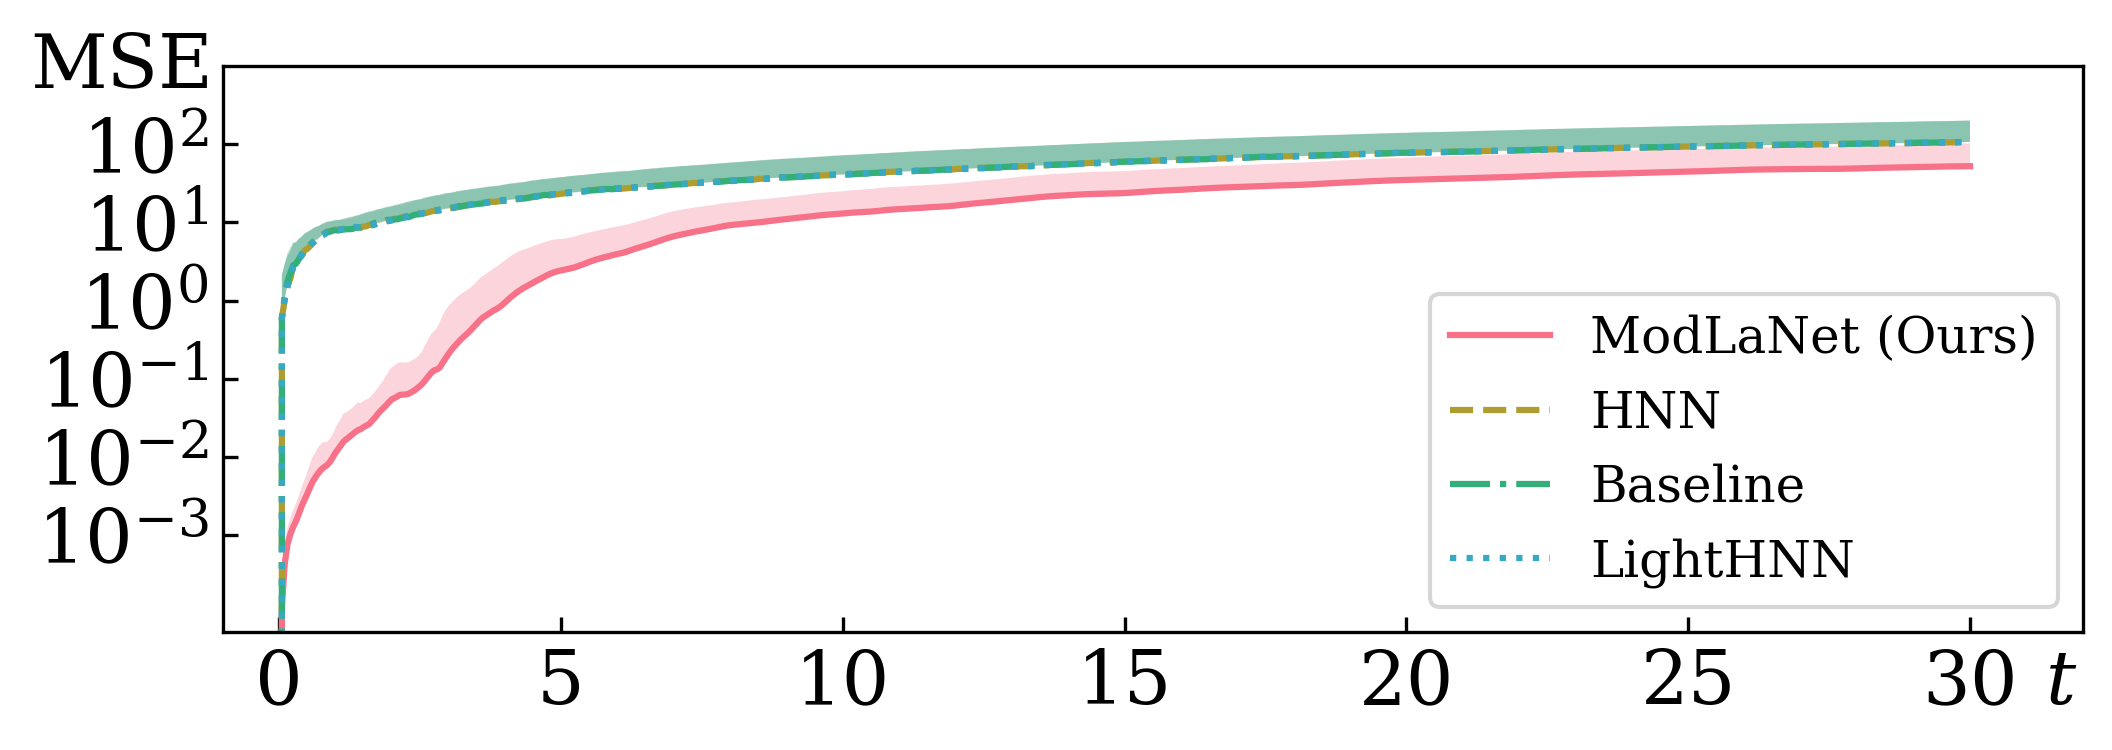

In [19]:
# Ref: https://stackoverflow.com/questions/43064524/plotting-shaded-uncertainty-region-in-line-plot-in-matplotlib-when-data-has-nans
import seaborn as sns
legendsize = 12

fig, ax = plt.subplots(figsize = [8, 2.5], dpi=DPI)
clrs = sns.color_palette("husl", 5)
labels = ['ModLaNet (Ours)', 'HNN', 'Baseline', 'LightHNN', 'LightBaseline']
lines  = ['solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5, 1, 5)),
          (0, (1, 10)), (0, (5, 10)), (0, (3, 10, 1, 10)), 
           (0, (3, 10, 1, 10, 1, 10))] #'loosely dotted', 'loosely dashed', 'loosely dashdotted', 'dashdotdotted' and 'loosely dashdotdotted'

x_array = np.array(x_list, dtype=np.float32)
# with sns.axes_style("darkgrid"):
epochs = np.linspace(t_span[0], t_span[1], end_time*timescale+1)
for i in range(num_models-1):
    x_error = x_array[i+1] - x_array[0]
    x_error = np.linalg.norm(x_error, axis = 1)
    meanst = np.mean(x_error, axis = 0)
    sdt = np.std(x_error, axis = 0)
    ax.plot(epochs, meanst, label=labels[i], c=clrs[i], linestyle=lines[i])
    ax.fill_between(epochs, meanst, meanst+sdt ,alpha=0.3, facecolor=clrs[i])
ax.legend(fontsize = legendsize)
ax.set_yscale('log')
ax.tick_params(axis="y", direction='in')#, length=8)
ax.tick_params(axis="x", direction='in')#, length=8)
ax.set_ylim(top=1e3)
ax.set_xlim([-1, 32])
ax.set_yticks([0.001, 0.01, 0.1, 1, 10, 100])
ax.annotate('$t$', xy=(0.98, -0.025), ha='left', va='top', xycoords='axes fraction')
ax.annotate('MSE', xy=(-0.07, 1.05), xytext=(-15,2), ha='left', va='top', xycoords='axes fraction', textcoords='offset points')

# ax.grid('on')
fig.savefig('{}/pend-2-100traj-pos.png'.format(args.result_dir))
# ax.set_ylabel('MSE of position ($m$)')
# ax.set_xlabel('Time ($s$)')


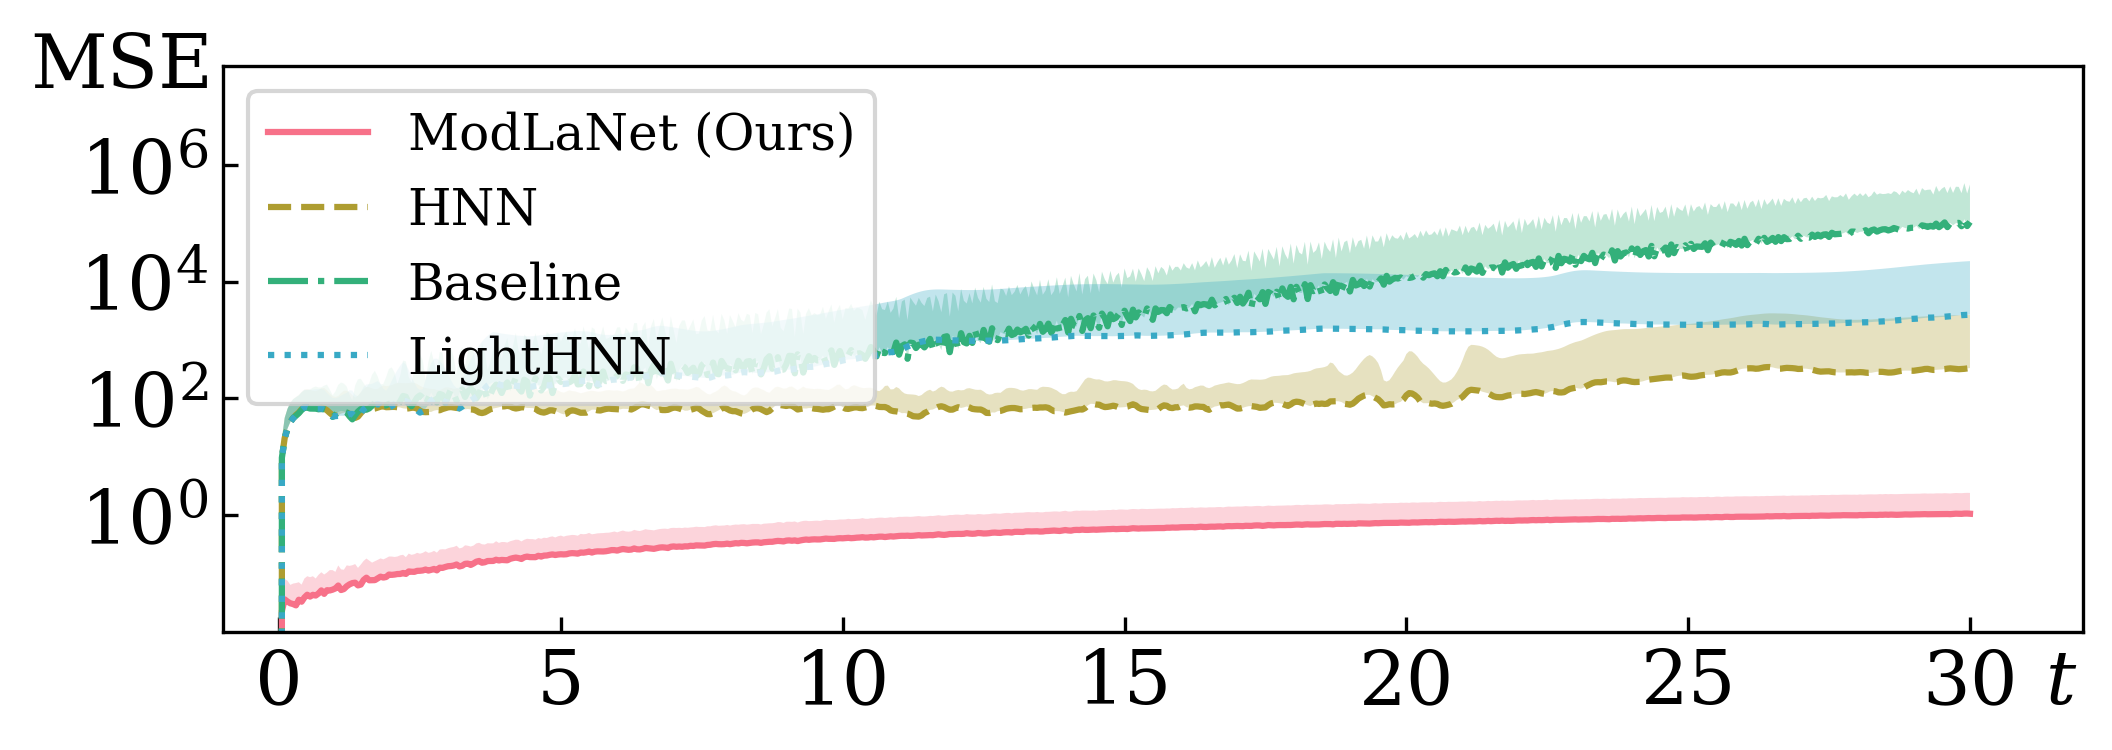

In [20]:
# Ref: https://stackoverflow.com/questions/43064524/plotting-shaded-uncertainty-region-in-line-plot-in-matplotlib-when-data-has-nans
import seaborn as sns

fig, ax = plt.subplots(figsize = [8, 2.5], dpi=DPI)
clrs = sns.color_palette("husl", 5)
labels = ['ModLaNet (Ours)', 'HNN', 'Baseline', 'LightHNN', 'LightBaseline']

e_array = np.array(e_list, dtype = np.float32)
# with sns.axes_style("darkgrid"):
epochs = np.linspace(t_span[0], t_span[1], end_time*timescale+1)
for i in range(num_models-1):
    e_error = e_array[i+1] - e_array[0]
    e_error = np.abs(e_error)
    meanst = np.mean(e_error, axis = 0)
    sdt = np.std(e_error, axis = 0)
    ax.plot(epochs, meanst, label=labels[i], c=clrs[i], linestyle=lines[i])
    ax.fill_between(epochs, meanst, meanst+sdt ,alpha=0.3, facecolor=clrs[i])
ax.legend(fontsize = legendsize)
ax.set_yscale('log')
ax.tick_params(axis="y", direction='in')#, length=8)
ax.tick_params(axis="x", direction='in')#, length=8)
ax.set_ylim(top=5e7)
ax.set_xlim([-1, 32])
ax.set_yticks([1, 100, 10000, 1e6])
ax.annotate('$t$', xy=(0.98, -0.025), ha='left', va='top', xycoords='axes fraction')
ax.annotate('MSE', xy=(-0.07, 1.05), xytext=(-15,2), ha='left', va='top', xycoords='axes fraction', textcoords='offset points')

# ax.grid('on')
fig.savefig('{}/pend-2-100traj-eng.png'.format(args.result_dir))
